In [ ]:
# Install requirements
!pip install pdfplumber pandas numpy matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.0 MB/s eta 0:00:00


In [ ]:
# Import dependencies
import re, pdfplumber, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [ ]:
# Upload PDF
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print("Processing:", pdf_path)

Saving \.pdf to \.pdf
Processing: \.pdf


In [ ]:
# ---------------------------------------------------------
# 📌 PDF → Transaction Extractor
# ---------------------------------------------------------
def extract_transactions_from_pdf(file_path):
    transactions = []
    amount_pattern = re.compile(r"([0-9]+\.[0-9]{2})")

    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if not text:
                continue

            for line in text.split("\n"):
                parts = line.split()

                if len(parts) < 3:
                    continue

                # Amount
                amt_match = amount_pattern.search(line.replace("■", ""))
                if not amt_match:
                    continue
                amount = float(amt_match.group(1))

                # Date
                date_match = re.match(r"(2025-\d{2}-\d{2})", parts[0])
                if not date_match:
                    continue
                date = date_match.group(1)

                # Category = last column
                category = parts[-1]

                # Description = middle text
                desc = " ".join(parts[1:-2])

                transactions.append({
                    "date": date,
                    "description": desc,
                    "amount": amount,
                    "category": category
                })

    return pd.DataFrame(transactions)

# Extract transactions
df = extract_transactions_from_pdf(pdf_path)
df['date'] = pd.to_datetime(df['date'])
df.head()


,date,description,amount,category
0,2025-08-15,Hospital Bill,4497.55,Health
1,2025-05-28,Mobile Recharge,3913.65,Bills
2,2025-09-20,Electricity Bill,2407.58,Bills
3,2025-05-17,Monthly Rent Payment,4790.86,Rent
4,2025-04-16,Monthly Rent Payment,3590.53,Rent


In [ ]:
# ---------------------------------------------------------
# 📌 Financial Summary
# ---------------------------------------------------------
def compute_financial_summary(df):
    total_income = df[df["amount"] < 0]["amount"].sum() * -1
    total_expenses = df[df["amount"] > 0]["amount"].sum()
    savings = total_income - total_expenses
    categories = df.groupby("category")["amount"].sum().to_dict()

    return {
        "total_income": round(total_income, 2),
        "total_expenses": round(total_expenses, 2),
        "savings": round(savings, 2),
        "categories": categories,
        "transactions": len(df)
    }

summary = compute_financial_summary(df)
print("\n===== FINANCIAL SUMMARY =====")
print(summary)



===== FINANCIAL SUMMARY =====
{'total_income': np.float64(-0.0), 'total_expenses': np.float64(336690.12), 'savings': np.float64(-336690.12), 'categories': {'Bills': 61455.61, 'Entertainment': 43218.85, 'Food': 37475.11, 'Fuel': 18638.41, 'Groceries': 34953.159999999996, 'Health': 40874.32, 'Rent': 51801.369999999995, 'Shopping': 21063.51, 'Travel': 27209.78}, 'transactions': 130}


In [ ]:
# ---------------------------------------------------------
# 📌 Monthly Trends
# ---------------------------------------------------------
df["month"] = df["date"].dt.to_period("M")
monthly_expense = df.groupby("month")["amount"].sum()

print("\n===== MONTHLY EXPENSES =====")
print(monthly_expense)


===== MONTHLY EXPENSES =====
month
2025-01    37759.99
2025-02    44851.76
2025-03    40624.82
2025-04    53295.26
2025-05    37219.52
2025-06    22417.36
2025-07    33292.28
2025-08    29751.72
2025-09    37477.41
Freq: M, Name: amount, dtype: float64


In [ ]:

# ---------------------------------------------------------
# 📌 Budget Prediction (ML)
# ---------------------------------------------------------
months = np.arange(len(monthly_expense)).reshape(-1, 1)
values = monthly_expense.values

model = LinearRegression()
model.fit(months, values)
next_month = np.array([[len(monthly_expense)]])
prediction = model.predict(next_month)[0]

print("\nPredicted next month expense: ₹", round(prediction, 2))


Predicted next month expense: ₹ 29745.56


In [ ]:
# ---------------------------------------------------------
# 📌 AI-GENERATED INSIGHTS
# ---------------------------------------------------------
def generate_insights(summary, monthly_expense, df, anomalies):
    insights = []

    # Insight 1: Savings Rate
    if summary["total_income"] == 0:
        insights.append("You have no recorded income in this statement.")
    else:
        savings_rate = (summary["savings"] / summary["total_income"]) * 100
        insights.append(f"Your savings rate is {round(savings_rate,2)}%. A healthy target is 20%.")

    # Insight 2: Biggest spending category
    biggest_cat = max(summary["categories"], key=summary["categories"].get)
    biggest_amt = summary["categories"][biggest_cat]
    insights.append(f"Your biggest spending category is {biggest_cat} with ₹{round(biggest_amt,2)}.")

    # Insight 3: Monthly trend direction
    if monthly_expense.iloc[-1] > monthly_expense.mean():
        insights.append("Your latest month spending is higher than average. Consider reviewing expenses.")
    else:
        insights.append("Your spending is below the monthly average. Good control!")

    # Insight 4: Anomalies
    insights.append(f"{len(anomalies)} unusual transactions detected. Review them for possible fraud or mistakes.")

    # Insight 5: Expense prediction insight
    if prediction > monthly_expense.mean():
        insights.append("Next month's predicted expenses may increase. Plan your budget accordingly.")
    else:
        insights.append("Next month’s expenses look stable based on current trends.")

    return insights

insights = generate_insights(summary, monthly_expense, df, anomalies)

print("\n===== AI-GENERATED INSIGHTS =====")
for tip in insights:
    print("•", tip)


===== AI-GENERATED INSIGHTS =====
• You have no recorded income in this statement.
• Your biggest spending category is Bills with ₹61455.61.
• Your latest month spending is higher than average. Consider reviewing expenses.
• 13 unusual transactions detected. Review them for possible fraud or mistakes.
• Next month’s expenses look stable based on current trends.


In [ ]:
# ---------------------------------------------------------
# 📌 Anomaly Detection
# ---------------------------------------------------------
iso = IsolationForest(contamination=0.1, random_state=42)
df["anomaly_score"] = iso.fit_predict(df[["amount"]])
anomalies = df[df["anomaly_score"] == -1]

print("\n===== ANOMALIES DETECTED =====")
print(anomalies.head())



===== ANOMALIES DETECTED =====
         date      description   amount       category    month  anomaly_score
9  2025-06-20  Spotify Premium   554.24  Entertainment  2025-06             -1
12 2025-09-16    Movie Tickets   696.92  Entertainment  2025-09             -1
15 2025-09-11   HP Petrol Pump  4804.36           Fuel  2025-09             -1
50 2025-04-27         Ola Ride  4393.09         Travel  2025-04             -1
55 2025-02-20       McDonald's   422.35           Food  2025-02             -1


In [ ]:
# ---------------------------------------------------------
# 📌 Clustering Spend Patterns
# ---------------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(df[["amount"]])

print("\n===== SAMPLE CLUSTERED DATA =====")
print(df.head())


===== SAMPLE CLUSTERED DATA =====
        date           description   amount category    month  anomaly_score  \
0 2025-08-15         Hospital Bill  4497.55   Health  2025-08              1   
1 2025-05-28       Mobile Recharge  3913.65    Bills  2025-05              1   
2 2025-09-20      Electricity Bill  2407.58    Bills  2025-09              1   
3 2025-05-17  Monthly Rent Payment  4790.86     Rent  2025-05              1   
4 2025-04-16  Monthly Rent Payment  3590.53     Rent  2025-04              1   

   cluster  
0        1  
1        1  
2        0  
3        1  
4        1  


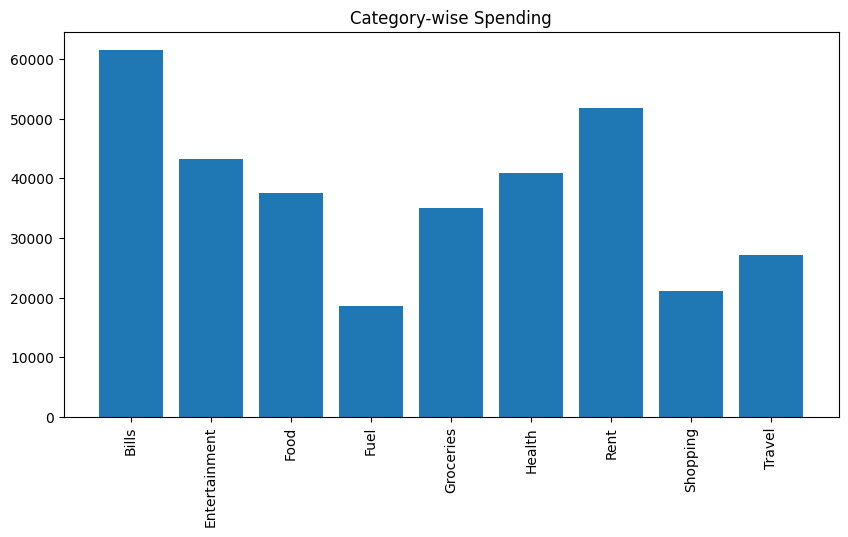

In [ ]:

# ---------------------------------------------------------
# 📌 Category-wise Spending Chart
# ---------------------------------------------------------
cat = summary["categories"]
plt.figure(figsize=(10,5))
plt.bar(cat.keys(), cat.values())
plt.xticks(rotation=90)
plt.title("Category-wise Spending")
plt.show()

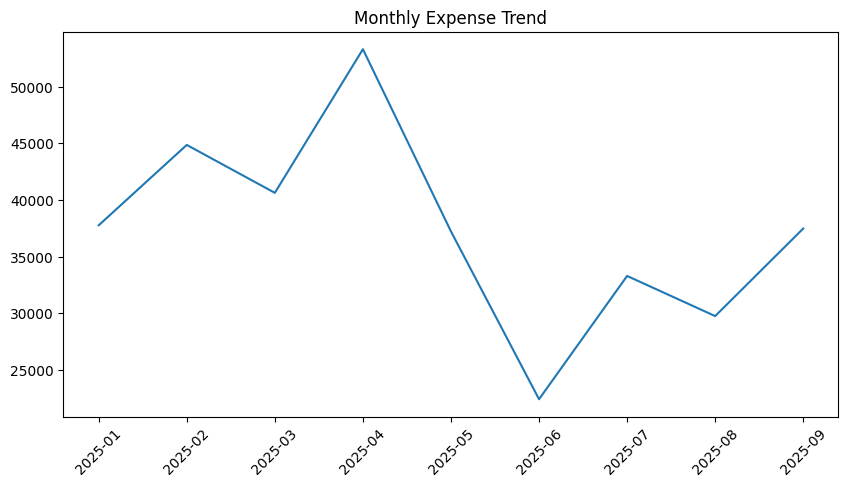

In [ ]:

# ---------------------------------------------------------
# 📌 Monthly Trend Chart
# ---------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(monthly_expense.index.astype(str), monthly_expense.values)
plt.xticks(rotation=45)
plt.title("Monthly Expense Trend")
plt.show()